In [84]:
# Bibliotheken laden
import pickle
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, root_mean_squared_error, accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Load data

In [4]:
# Datensatz X und y mit numpy laden, da es für sklearn benötigt wird
X_test = np.loadtxt('X_test.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

X_train = np.loadtxt('X_train_processed.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

## Transform Test Data

In [6]:
class CustomFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
    # Initialize any parameters you need here
        pass

    def fit(self, X, y=None):
    # Fit the transformer to the data (e.g. compute any necessary statistics)
        return self

    def transform(self, X):
# Create the custom features
# Balance refers to the relationship between the four essential elements of wine:
# tannin, acidity, alcohol and sugar.
# Je süßer der Wein desto mehr Säure verträgt er
        acids = X[:,:2].sum(axis=1)
        acids_per_sugar = acids / X[:,3]
        acids_per_alc = acids / X[:, 10]
        alc_per_sugar = X[:, 10] / X[:,3]
        sulf_per_sugar = X[:,6] / X[:, 3]

        new_f = np.column_stack((acids_per_sugar, acids_per_alc, alc_per_sugar, sulf_per_sugar))
        #new_f_inv = 1 / new_f

        X = np.hstack((X, new_f)) #new_f_inv

# um mehr Zucker muss mehr schwefel hinzugefügt werden um Fermentation zu stoppen

# Zucker wird zu Alkohol

        return X

In [7]:
with open('preprocessing_pipeline.pkl', 'rb') as p_file:
    preproc_pipe = pickle.load(p_file)

In [8]:
X_test_processed = preproc_pipe.transform(X_test)

In [9]:
X_test.shape, X_test_processed.shape

((272, 11), (272, 15))

In [10]:
# Support Vector Machine - erster Durchlauf um einen Accuracy Score zu erhalten
model = SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
model.fit(X_train,y_train)
print(f"Mean Accuracy of SVC:", np.round(model.score(X_train,y_train)))

Mean Accuracy of SVC: 1.0


In [11]:
# Cross Val Score um accuracy zu vergleichen
cvs = cross_val_score(model, X_train,y_train, scoring='accuracy', cv=5)
print(cvs) # overfitting
print("%0.2f accuracy with a standard deviation of %0.2f" % (cvs.mean(), cvs.std()))

[0.56880734 0.56880734 0.56221198 0.62211982 0.57603687]
0.58 accuracy with a standard deviation of 0.02


In [12]:
# Pipeline mit PCA und SVC erstellen

model = make_pipeline(PCA(), SVC(probability=True, random_state=42, decision_function_shape='ovo'))

In [13]:
# Funktion für die Auswertung nach dem fit
def auswertung(model, X_train,y_train):
    #model.fit(X_train,y_train)
    print("__________________________________________________________")
    print("Best Estimator= ", model_gs.best_estimator_) # bestes Model für die Vorhersage mit dem höchsten Score
    print("Best Score:",model_gs.best_score_) # Wie hoch ist der beste Score
    print("Best Parameter:", model_gs.best_params_) # Die besten Parameter
    print(pd.DataFrame({k:v for k, v in model_gs.cv_results_.items() if not k.endswith('time')|k.startswith('split')|k.startswith('params')}))



# Hauptfunktion - Exhaustive GridSearch
print()
print("///////////////////////////////////////////////////////////////// ")

start = time.time()
params = [{'pca__n_components': [13,14,15], 'svc__C': [1,10,100],
           'svc__kernel': ['linear']},
          {'pca__n_components': [13,14,15], 'svc__C': [1,10,100], 'svc__kernel': ['poly'],
           'svc__degree': [2,3,4], 'svc__gamma': ['scale', 'auto'],
           'svc__coef0': [1,5,10]},
          {'pca__n_components': [13,14,15], 'svc__C': [1,10,100], 'svc__kernel': ['rbf'],
           'svc__gamma': ['scale', 'auto']},
          {'pca__n_components': [13,14,15], 'svc__C': [1,10,100],
           'svc__kernel': ['sigmoid'], 'svc__gamma': ['scale', 'auto'], 'svc__coef0': [1,5,10]}]
model_gs = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', return_train_score=True)
# return_train_score - Verhältnis train zu test score
model_gs.fit(X_train,y_train)
end = time.time()
print(f"Rechenzeit:", end-start)
auswertung(model_gs, X_train,y_train)


///////////////////////////////////////////////////////////////// 
Rechenzeit: 5568.98595905304
__________________________________________________________
Best Estimator=  Pipeline(steps=[('pca', PCA(n_components=14)),
                ('svc',
                 SVC(C=1, decision_function_shape='ovo', probability=True,
                     random_state=42))])
Best Score: -0.7260555711745849
Best Parameter: {'pca__n_components': 14, 'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
     param_pca__n_components  param_svc__C param_svc__kernel  \
0                         13             1            linear   
1                         13            10            linear   
2                         13           100            linear   
3                         14             1            linear   
4                         14            10            linear   
..                       ...           ...               ...   
238                       15           100           sigmoid

In [28]:
# Erstellung eines DataFrames aus den Grid Search-Ergebnissen
# Dictionary mit entsprechenden Spalten herausfiltern
cv_res_df = pd.DataFrame({k:v for k, v in model_gs.cv_results_.items() if not k.endswith('time')|k.startswith('split')|k.startswith('params')})
cv_res_df.sort_values('mean_test_score', ascending=False).head(5)

,param_pca__n_components,param_svc__C,param_svc__kernel,param_svc__coef0,param_svc__degree,param_svc__gamma,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
177,14,1,rbf,NaN,NaN,scale,-0.726056,0.029197,1,-0.661606,0.013475
184,15,1,rbf,NaN,NaN,auto,-0.728533,0.030574,2,-0.665779,0.012707
183,15,1,rbf,NaN,NaN,scale,-0.728533,0.030574,2,-0.665081,0.013077
172,13,1,rbf,NaN,NaN,auto,-0.729069,0.032405,4,-0.654341,0.008996
178,14,1,rbf,NaN,NaN,auto,-0.729100,0.031898,5,-0.658375,0.008787


In [36]:
# Confusion Matrix für den besten Estimator
y_true = y_train
y_pred = model_gs.predict(X_train)
con_matrix=confusion_matrix(y_true, y_pred) # sagt eine echte 8 als 6 (8Mal) und als 7 (6Mal) voraus --> schlecht
con_matrix

array([[  0,   0,   6,   2,   0,   0],
       [  0,   1,  27,  13,   1,   0],
       [  0,   0, 376,  84,   1,   0],
       [  0,   0, 110, 312,   6,   0],
       [  0,   0,   6,  84,  44,   0],
       [  0,   0,   0,   9,   5,   0]])

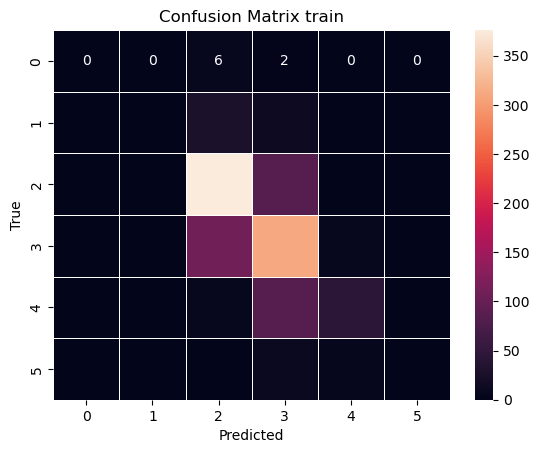

In [92]:
# Plot der Confusion Matrix für y_true und y_predicted
fig, ax = plt.subplots()
ax = sns.heatmap(con_matrix, annot=True, linewidth=.5)
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix train')
plt.show()

In [58]:
#best params: {'pca__n_components': 14, 'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
# Modelltraining
svc_pipe = make_pipeline(PCA(n_components=14),
                      SVC(probability=True, random_state=42, decision_function_shape='ovo',
                          C=1, kernel='rbf', gamma='scale'))
svc_pipe.fit(X_train, y_train)

# Vorhersagen auf Trainings- und Testdaten
y_train_pred_svc = svc_pipe.predict(X_train)
y_test_pred_svc = svc_pipe.predict(X_test_processed)

#### RMSE berechnen

In [66]:
print(f'RMSE_train: {np.round(root_mean_squared_error(y_train, y_train_pred_svc), decimals=2)}')
print(f'RMSE_test: {np.round(root_mean_squared_error(y_test, y_test_pred_svc), decimals=2)}')

RMSE_train: 0.67
RMSE_test: 0.71


#### Accuracy berechnen

In [80]:
accuracy_train = np.round(accuracy_score(y_train, y_train_pred_svc), decimals=2)
accuracy_test = np.round(accuracy_score(y_test, y_test_pred_svc), decimals=2)
print(f"Accuracy Train:", accuracy_train)
print(f"F1-Score Train:", accuracy_test)

Accuracy Train: 0.67
F1-Score Train: 0.61


#### F1-Score berechnen

In [76]:
f1_train = np.round(f1_score(y_train, y_train_pred_svc, average='macro'), decimals=2)
f1_test = np.round(f1_score(y_test, y_test_pred_svc, average='macro'), decimals=2)
print(f"F1-Score Train:", f1_train)
print(f"F1-Score Test:", f1_test)

F1-Score Train: 0.32
F1-Score Test: 0.27


#### Confusion Matrix berechnen und visualisieren

[[ 0  0  1  1  0  0]
 [ 0  0 10  1  0  0]
 [ 0  0 88 27  1  0]
 [ 0  0 32 70  5  0]
 [ 0  0  3 23  7  0]
 [ 0  0  0  2  1  0]]


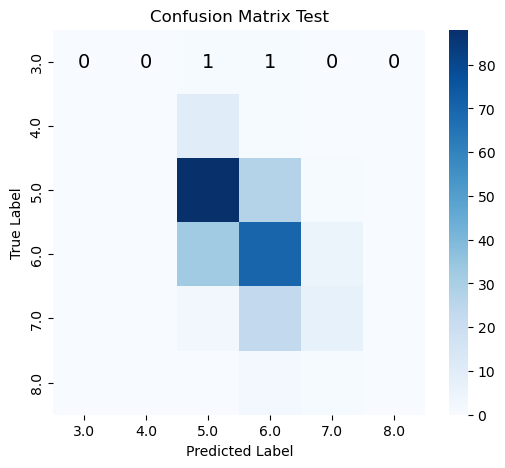

In [121]:
conf_matrix = confusion_matrix(y_test, y_test_pred_svc)
print(conf_matrix)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test),  
            yticklabels=np.unique(y_test),
            annot_kws={"size": 14, "color": "black"})  # Größe und Farbe der Zahlen anpassen) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Test')
plt.show()

#### Detaillierter Bericht zur Klassifikation

In [125]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_svc, digits=4))


Classification Report:

              precision    recall  f1-score   support

         3.0     0.0000    0.0000    0.0000         2
         4.0     0.0000    0.0000    0.0000        11
         5.0     0.6567    0.7586    0.7040       116
         6.0     0.5645    0.6542    0.6061       107
         7.0     0.5000    0.2121    0.2979        33
         8.0     0.0000    0.0000    0.0000         3

    accuracy                         0.6066       272
   macro avg     0.2869    0.2708    0.2680       272
weighted avg     0.5628    0.6066    0.5748       272



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [132]:
print("Echte Klassen in y_test:", np.unique(y_test))
print("Vorhergesagte Klassen in y_test_pred_svc:", np.unique(y_test_pred_svc))

Echte Klassen in y_test: [3. 4. 5. 6. 7. 8.]
Vorhergesagte Klassen in y_test_pred_svc: [5. 6. 7.]


#### Das Ergebnis des Classification Reports bestätigt die Annahme hinsichtlich der Verteilung.
#### Aufgrund der unausgewogenen Datenverteilung, werden die Kategorien **3, 4 und 8** überhaupt nicht vorhergesagt.